# KernelRegressionHead 端到端验证测试

本 notebook 使用与 `KRFD_Power factor_1.0.ipynb` 相同的数据，
通过 `FlexibleMultiTaskModel` + `CompoundDataModule` 完整生产代码路径，
验证修复后的 `KernelRegressionHead` 的表现。

## 验证方式
- 使用 `CompoundDataModule`（生产 DataModule）加载数据
- 使用 `FlexibleMultiTaskModel` + `MLPEncoderConfig` + `KernelRegressionTaskConfig` 构建模型
- 训练/验证/预测流程完全走生产代码路径，与 `dynamic_task_suite.py` 一致

In [9]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from IPython.core.interactiveshell import InteractiveShell
from KRFD_helper import swap_train_val_split
from KRFD_utils import init_centers_and_sigmas
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.metrics import mean_absolute_error, r2_score

# Import production components
from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    KernelRegressionTaskConfig,
    MLPEncoderConfig,
    OptimizerConfig,
)

InteractiveShell.instance().ast_node_interactivity = "all"
torch.set_float32_matmul_precision("medium")

## 1. 加载数据并准备 CompoundDataModule 所需的 DataFrame 格式

In [10]:
import joblib
from pymatgen.core import Composition

preprocessing_objects = joblib.load("../data/preprocessing_objects_20250615.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[
    ~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])
]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("../data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet")

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to un

In [11]:
# --- 确保 Material type != "others" 且 composition 为 4 元及以上的样本在 test 集中 ---
# 全局处理：直接修改 qc_ac_te_mp_dos_data 的 split 列
# 之后 swap_train_val_split 只交换 train/val，不会影响这些已固定在 test 中的样本

def enforce_quaternary_in_test(df, random_seed=42, return_detail="moved_to_test"):
    """
    确保 Material type != 'others' 且 composition 元素数 >= 4 的样本在 test 集中。
    如果这些样本当前不在 test 中，则与 test 中的样本 1:1 交换。
    直接修改 df 的 split 列。

    Parameters
    ----------
    df : pd.DataFrame
        包含 'split', 'Material type', 'composition' 列的 DataFrame
    random_seed : int
        随机种子
    return_detail : str
        控制返回的交换信息：
        - "moved_to_test": 只返回被移入 test 的 index (pd.Index)
        - "full": 返回完整交换字典 {"moved_to_test": pd.Index, "moved_out_of_test": pd.Index,
          "swaps": dict[idx_in -> idx_out], "forced": pd.Index}

    Returns
    -------
    df : pd.DataFrame
        修改后的 DataFrame
    detail : pd.Index | dict
        根据 return_detail 参数返回不同粒度的交换信息
    """
    rng = np.random.default_rng(random_seed)

    mask_material = df["Material type"] != "others"
    mask_quaternary = df["composition"].apply(lambda c: len(c) >= 4)
    target_mask = mask_material & mask_quaternary

    needs_move = target_mask & (df["split"] != "test")
    move_idx = df.index[needs_move]
    n_move = len(move_idx)

    empty_result = (
        pd.Index([]) if return_detail == "moved_to_test"
        else {"moved_to_test": pd.Index([]), "moved_out_of_test": pd.Index([]),
              "swaps": {}, "forced": pd.Index([])}
    )

    if n_move == 0:
        print("所有符合条件的样本已在 test 集中，无需交换。")
        return df, empty_result

    # 可交换出去的 test 样本：在 test 中但不符合 4 元+ 条件
    swappable_test = (df["split"] == "test") & ~target_mask
    swappable_test_idx = df.index[swappable_test]

    n_swap = min(n_move, len(swappable_test_idx))
    if n_swap < n_move:
        print(f"警告：test 中可交换样本数 ({len(swappable_test_idx)}) < 需移入数 ({n_move})，"
              f"剩余 {n_move - n_swap} 个直接移入 test。")

    swap_out_idx = rng.choice(swappable_test_idx, n_swap, replace=False)
    swap_in_idx = move_idx[:n_swap]
    original_splits = df.loc[swap_in_idx, "split"].values

    swap_dict = {}
    for i, (in_i, out_i) in enumerate(zip(swap_in_idx, swap_out_idx)):
        df.loc[out_i, "split"] = original_splits[i]
        df.loc[in_i, "split"] = "test"
        swap_dict[in_i] = out_i

    # 剩余无法交换的直接移入 test
    forced_idx = move_idx[n_swap:]
    if len(forced_idx) > 0:
        df.loc[forced_idx, "split"] = "test"

    all_moved_to_test = move_idx  # swap_in + forced 都移入了 test

    if return_detail == "moved_to_test":
        return df, all_moved_to_test
    else:
        return df, {
            "moved_to_test": all_moved_to_test,
            "moved_out_of_test": pd.Index(swap_out_idx),
            "swaps": swap_dict,       # {moved_in_idx: moved_out_idx}
            "forced": forced_idx,     # 无法 1:1 交换，直接移入的
        }


# 全局执行
mask_not_others = qc_ac_te_mp_dos_data["Material type"] != "others"
mask_quat = qc_ac_te_mp_dos_data["composition"].apply(lambda c: len(c) >= 4)
target_global = mask_not_others & mask_quat
print(f"全局 Material type != 'others' 且 4 元及以上化合物: {target_global.sum()} 个")
print(f"处理前 split 分布: {qc_ac_te_mp_dos_data.loc[target_global, 'split'].value_counts().to_dict()}")

qc_ac_te_mp_dos_data, swap_detail = enforce_quaternary_in_test(
    qc_ac_te_mp_dos_data, random_seed=42, return_detail="full"
)
print(f"\n移入 test: {len(swap_detail['moved_to_test'])} 个 (其中 1:1 交换: {len(swap_detail['swaps'])}, 直接移入: {len(swap_detail['forced'])})")
print(f"处理后 split 分布: {qc_ac_te_mp_dos_data.loc[target_global, 'split'].value_counts().to_dict()}")
print(f"全局 split 分布: {qc_ac_te_mp_dos_data['split'].value_counts().to_dict()}")

全局 Material type != 'others' 且 4 元及以上化合物: 82 个
处理前 split 分布: {'train': 59, 'test': 12, 'val': 11}

移入 test: 70 个 (其中 1:1 交换: 70, 直接移入: 0)
处理后 split 分布: {'test': 82}
全局 split 分布: {'train': 34295, 'test': 7354, 'val': 7349}


In [16]:
t = qc_ac_te_mp_dos_data[['Material type', 'split']]

In [17]:
t.groupby('split').value_counts()

split  Material type
test   others            7228
       IQC                 83
       IAC                 32
       DQC                  9
       DAC                  2
train  others           34098
       IQC                106
       IAC                 76
       DAC                 10
       DQC                  5
val    others            7305
       IQC                 24
       IAC                 18
       DAC                  1
       DQC                  1
Name: count, dtype: int64

In [3]:
_ = [
    "Thermal conductivity",   # 0
    "Electrical resistivity", # 1
    "Power factor",           # 2
    "Seebeck coefficient",    # 3
    "ZT",                     # 4
    "Magnetic susceptibility",# 5
    "DOS density",            # 6
]

OUTLIER = None
prop_name = _[2]

prop_value = qc_ac_te_mp_dos_data[prop_name].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop_name} (normalized)"].loc[prop_value.index]
prop_T = (
    qc_ac_te_mp_dos_data[f"{prop_name} (T/K)"].loc[prop_value.index]
    if prop_name != "DOS density"
    else qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
)

if OUTLIER is not None and OUTLIER:
    mask = prop_T.apply(lambda arr: np.all(np.asarray(arr) <= OUTLIER))
    prop_value = prop_value[mask]
    prop_value_norm = prop_value_norm[mask]
    prop_T = prop_T[mask]

serial_name = "Temperature (K)" if prop_name != "DOS density" else r"$E - E_{ferim}$ (eV)"
desc = desc_trans.loc[prop_value.index]

# --- 准备 CompoundDataModule 所需的 attributes DataFrame ---
# CompoundDataModule 需要一个 attributes DataFrame，其中包含：
#   - data_column: 目标值列（每个 cell 是一个 list/array，即变长序列）
#   - t_column: t 参数列（每个 cell 是一个 list/array）
#   - split: 数据划分列（train/val/test）
DATA_COLUMN = f"{prop_name} (normalized)"
T_COLUMN = f"{prop_name} (T/K)" if prop_name != "DOS density" else "DOS energy"

# 构建 attributes DataFrame，只包含有数据的样本
attributes_df = qc_ac_te_mp_dos_data.loc[prop_value.index, [DATA_COLUMN, T_COLUMN]].copy()

print(f"Property: {prop_name}")
print(f"Samples: {len(attributes_df)}, x_dim: {desc.shape[1]}")
print(f"data_column: '{DATA_COLUMN}', t_column: '{T_COLUMN}'")
print(f"Sample target (first): length={len(attributes_df[DATA_COLUMN].iloc[0])}")
print(f"Sample t (first): length={len(attributes_df[T_COLUMN].iloc[0])}")

Property: Power factor
Samples: 5219, x_dim: 290
data_column: 'Power factor (normalized)', t_column: 'Power factor (T/K)'
Sample target (first): length=300
Sample t (first): length=300


## 2. 配置超参数、初始化 kernel centers/sigmas

Seed set to 2025


2025

centers: tensor([  12.3750,   99.2540,  231.0329,  395.3677,  583.8301,  762.0736,
         913.1929, 1033.5565, 1128.0890, 1206.1077, 1271.0336, 1317.4774,
        1360.6561, 1403.8484, 1445.6250])
sigmas : tensor([43.4395, 54.6645, 74.0284, 88.1993, 91.6765, 82.3407, 67.8707, 53.7240,
        43.1378, 35.7361, 27.8424, 22.4056, 21.5927, 21.2422, 20.8883])

Encoder: input_dim=290, latent_dim=64
Task: x_dim=[64, 128, 64], t_dim=[16, 8], enable_mu3=False


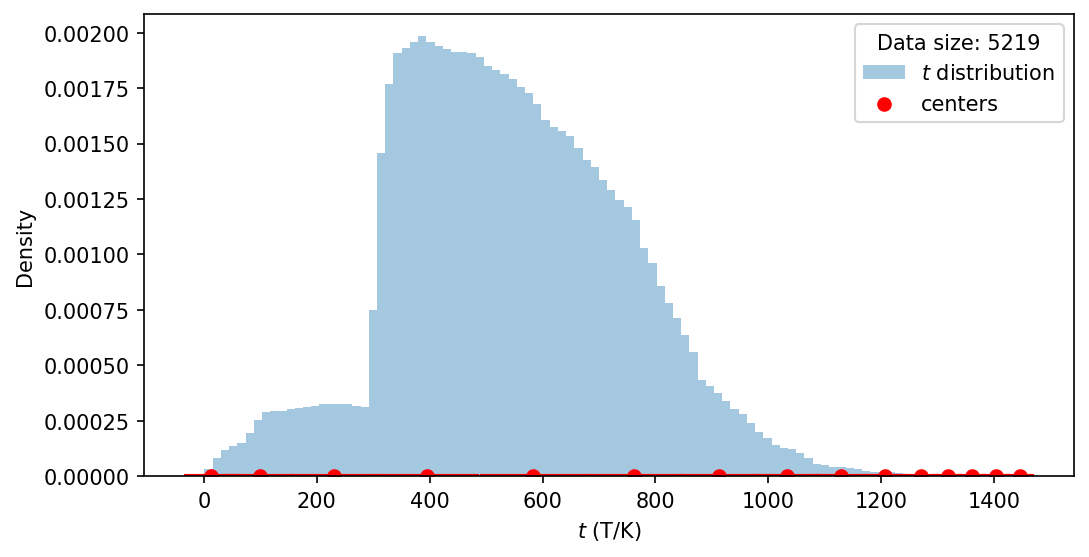

In [6]:
seed_everything(2025)

# -------------------------
# Hyperparameters (same as prototype notebook)
# -------------------------
EPOCHS = 10
N_TRY = 3  # reduced for testing; set to 10 for full runs
BATCH_SIZE = 16
TRAIN_RATIO = 1.0
DEVICE_NUM = 0
N_KERNEL = 15
LR_RATE = 5e-4
OTHER_DECAY = 5e-5
TASK_NAME = "power_factor"

x_dim = desc.shape[1]
LATENT_DIM = 64

# --- Encoder config ---
encoder_config = MLPEncoderConfig(
    hidden_dims=[x_dim, 128, LATENT_DIM],
    norm=True,
    residual=False,
)

# --- Initialize kernel centers/sigmas from t distribution ---
t_train = np.concatenate(prop_T.values)
t_range = (t_train.min(), t_train.max())

centers, sigmas = init_centers_and_sigmas(
    t_train=t_train,
    n_kernels=N_KERNEL,
    method="quantile",
    sigma_alpha=0.5,
    t_range=t_range,
    inverse_density=True,
    density_smoothing=0.8,
)

# --- KernelRegressionTaskConfig ---
task_config = KernelRegressionTaskConfig(
    name=TASK_NAME,
    data_column=DATA_COLUMN,
    t_column=T_COLUMN,
    # x_dim[0] = latent_dim from encoder
    x_dim=[LATENT_DIM, 128, 64],
    t_dim=[16, 8],
    norm=True,
    residual=False,
    # Kernel options
    kernel_num_centers=N_KERNEL,
    kernel_learnable_centers=True,
    kernel_learnable_sigmas=True,
    kernel_centers_init=centers.tolist(),
    kernel_sigmas_init=sigmas.tolist(),
    # Branch hidden dim overrides (matches prototype)
    beta_hidden_dims=[128, 64],
    mu1_hidden_dims=[128, 64],
    mu2_hidden_dims=[16, 8],
    mu3_hidden_dims=[128, 64],
    enable_mu3=False,
    # Optimizer for this task head
    optimizer=OptimizerConfig(
        optimizer_type="AdamW",
        lr=LR_RATE,
        weight_decay=OTHER_DECAY,
        scheduler_type="None",
    ),
)

print("centers:", centers)
print("sigmas :", sigmas)
print(f"\nEncoder: input_dim={x_dim}, latent_dim={LATENT_DIM}")
print(f"Task: x_dim={task_config.x_dim}, t_dim={task_config.t_dim}, enable_mu3={task_config.enable_mu3}")

# Plot distribution and centers/sigmas
_ = plt.figure(figsize=(8, 4), dpi=150)
_ = plt.hist(t_train, bins=100, density=True, alpha=0.4, label=r"$t$ distribution")
centers_np = centers.numpy()
sigmas_np = sigmas.numpy()
_ = plt.scatter(centers_np, np.zeros_like(centers_np), color="red", label="centers")
for c, s in zip(centers_np, sigmas_np):
    _ = plt.plot([c - s, c + s], [0, 0], color="red", lw=2)
_ = plt.xlabel(r"$t$ (T/K)")
_ = plt.ylabel("Density")
_ = plt.legend(title=f"Data size: {len(prop_T)}")
_ = plt.show()

## 3. 验证模型结构

In [7]:
# Instantiate model to inspect structure
model = FlexibleMultiTaskModel(
    task_configs=[task_config],
    encoder_config=encoder_config,
    shared_block_optimizer=OptimizerConfig(
        optimizer_type="AdamW", lr=LR_RATE, weight_decay=OTHER_DECAY, scheduler_type="None",
    ),
)

print("=== FlexibleMultiTaskModel structure ===")
print(model)
print()

# Verify KernelRegressionHead output layers have no BatchNorm
head = model.task_heads[TASK_NAME]
for name, net in [("beta_net", head.beta_net), ("mu1_net", head.mu1_net), ("mu2_net", head.mu2_net)]:
    last_layer = list(net.layers.modules())[-1]
    has_norm = hasattr(last_layer, "normal") and last_layer.normal is not None
    print(f"{name} output layer has BatchNorm: {has_norm} (expected: False)")

if head.mu3_net is not None:
    last_layer = list(head.mu3_net.layers.modules())[-1]
    has_norm = hasattr(last_layer, "normal") and last_layer.normal is not None
    print(f"mu3_net output layer has BatchNorm: {has_norm} (expected: False)")
else:
    print("mu3_net: disabled (enable_mu3=False)")

# Quick forward pass sanity check
x_test = torch.randn(4, x_dim)
t_test_seq = {TASK_NAME: [torch.randn(10) for _ in range(4)]}
with torch.no_grad():
    out = model(x_test, t_test_seq)
print(f"\nForward: x={x_test.shape}, t_seq=4x[10] -> output={out[TASK_NAME].shape}")

del model  # free memory before training loop

2026-02-10 03:25:34.752 | INFO     | flexible_multi_task_model:__init__:160 - Learnable task uncertainty (task_log_sigmas) is DISABLED.
2026-02-10 03:25:34.757 | INFO     | flexible_multi_task_model:__init__:181 - Initializing FlexibleMultiTaskModel...
2026-02-10 03:25:34.757 | INFO     | flexible_multi_task_model:__init__:182 - Registered Task Heads:
2026-02-10 03:25:34.758 | INFO     | flexible_multi_task_model:__init__:189 -           name             type  enabled
2026-02-10 03:25:34.758 | INFO     | flexible_multi_task_model:__init__:189 -   power_factor KernelRegression     True
2026-02-10 03:25:34.758 | INFO     | flexible_multi_task_model:__init__:193 - FlexibleMultiTaskModel Structure:
2026-02-10 03:25:34.759 | INFO     | flexible_multi_task_model:__init__:197 -   FlexibleMultiTaskModel(
2026-02-10 03:25:34.759 | INFO     | flexible_multi_task_model:__init__:197 -     (task_log_sigmas): ParameterDict()
2026-02-10 03:25:34.759 | INFO     | flexible_multi_task_model:__init__:197

=== FlexibleMultiTaskModel structure ===
FlexibleMultiTaskModel(
  (task_log_sigmas): ParameterDict()
  (encoder): FoundationEncoder(
    (shared): LinearBlock(
      (layers): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=290, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): LinearLayer(
          (layer): Linear(in_features=128, out_features=64, bias=True)
          (normal): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
      )
    )
  )
  (task_heads): ModuleDict(
    (power_factor): KernelRegressionHead(
      (kernel): _GaussianKernel()
      (beta_net): LinearBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): LinearLayer(
              (layer): Linear(in_features=64, o

## 4. 训练与评估

使用 `CompoundDataModule` + `FlexibleMultiTaskModel` 的完整生产流程。
预测使用 `trainer.predict()`，输出格式为 `{task_name_value: List[np.ndarray]}`。

Seed set to 2025
2026-02-10 03:25:50.145 | INFO     | datamodule:__init__:299 - Initializing CompoundDataModule...
2026-02-10 03:25:50.146 | INFO     | datamodule:__init__:336 - --- Loading Data ---
2026-02-10 03:25:50.146 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'formula_desc' data.
2026-02-10 03:25:50.147 | INFO     | datamodule:_load_data:630 - Successfully loaded 'formula_desc'. Shape: (5219, 290)
2026-02-10 03:25:50.147 | INFO     | datamodule:__init__:341 - Initial loaded formula_df length: 5219
2026-02-10 03:25:50.149 | INFO     | datamodule:__init__:348 - Formula_df length after initial dropna: 5219. This index is now the master reference.
2026-02-10 03:25:50.149 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'attributes' data.
2026-02-10 03:25:50.150 | INFO     | datamodule:_load_data:630 - Successfully loaded 'attributes'. Shape: (5219, 3)
2026-02-10 03:25:50.150 | INFO     | datamodule:__init__:362 - Initial loaded at


--- Training FlexibleMultiTaskModel with KernelRegressionHead ---


2026-02-10 03:25:50.327 | INFO     | dataset:__init__:100 - [val_dataset] Initializing CompoundDataset...
2026-02-10 03:25:50.327 | INFO     | dataset:__init__:106 - [val_dataset] Task masking RNG seeded with 20042.
2026-02-10 03:25:50.327 | INFO     | dataset:__init__:138 - [val_dataset] Final x_formula shape: torch.Size([801, 290])
2026-02-10 03:25:50.327 | INFO     | dataset:__init__:153 - [val_dataset] Processing enabled task 'power_factor' (type: KERNEL_REGRESSION)
2026-02-10 03:25:50.339 | INFO     | dataset:__init__:350 - [val_dataset] CompoundDataset initialization complete. Processed 1 enabled tasks.
2026-02-10 03:25:50.339 | INFO     | datamodule:setup:895 - --- DataModule setup for stage 'TrainerFn.FITTING' complete ---

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 0      | train
1 | encoder             | FoundationEncoder | 45.9 K | train
2 | task

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|█████████▉| 227/228 [00:04<00:00, 54.55it/s, v_num=al_1, train_final_loss_step=0.612]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   4%|▎         | 8/228 [00:00<00:03, 55.44it/s, v_num=al_1, train_final_loss_step=0.674, val_final_loss=0.571, train_final_loss_epoch=0.787]  

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 228/228 [00:04<00:00, 49.37it/s, v_num=al_1, train_final_loss_step=0.347, val_final_loss=0.403, train_final_loss_epoch=0.462]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 228/228 [00:04<00:00, 49.35it/s, v_num=al_1, train_final_loss_step=0.347, val_final_loss=0.403, train_final_loss_epoch=0.462]


2026-02-10 03:26:37.673 | INFO     | datamodule:setup:735 - --- Setting up DataModule for stage: fit ---
2026-02-10 03:26:37.673 | INFO     | datamodule:setup:745 - Total samples available before splitting (from attributes_df index): 5219
2026-02-10 03:26:37.674 | INFO     | datamodule:setup:756 - Data split strategy: Using 'split' column from attributes_df.
2026-02-10 03:26:37.674 | INFO     | datamodule:setup:758 - Value counts in 'split' column: {'train': 3638, 'val': 801, 'test': 780}
2026-02-10 03:26:37.676 | INFO     | datamodule:setup:848 - Final dataset sizes after splitting: Train=3638, Validation=801, Test=780
2026-02-10 03:26:37.676 | INFO     | datamodule:_build_fit_datasets:653 - --- Creating 'fit' stage datasets (train/val) ---
2026-02-10 03:26:37.676 | INFO     | datamodule:_build_fit_datasets:655 - Creating train_dataset with 3638 samples.
2026-02-10 03:26:37.677 | INFO     | dataset:__init__:100 - [train_dataset] Initializing CompoundDataset...
2026-02-10 03:26:37.678 

Predicting DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 86.47it/s] 


2026-02-10 03:26:38.379 | INFO     | datamodule:setup:735 - --- Setting up DataModule for stage: TrainerFn.PREDICTING ---
2026-02-10 03:26:38.379 | INFO     | datamodule:setup:745 - Total samples available before splitting (from attributes_df index): 5219
2026-02-10 03:26:38.379 | INFO     | datamodule:setup:756 - Data split strategy: Using 'split' column from attributes_df.
2026-02-10 03:26:38.380 | INFO     | datamodule:setup:758 - Value counts in 'split' column: {'train': 3638, 'val': 801, 'test': 780}
2026-02-10 03:26:38.381 | INFO     | datamodule:setup:848 - Final dataset sizes after splitting: Train=3638, Validation=801, Test=780
2026-02-10 03:26:38.381 | INFO     | datamodule:setup:878 - --- Creating 'predict' stage dataset ---
2026-02-10 03:26:38.382 | INFO     | dataset:__init__:100 - [predict_dataset] Initializing CompoundDataset...
2026-02-10 03:26:38.382 | INFO     | dataset:__init__:106 - [predict_dataset] Task masking RNG seeded with 20042.
2026-02-10 03:26:38.382 | INFO

Predicting DataLoader 0: 100%|██████████| 228/228 [00:01<00:00, 125.65it/s]


Text(0.5, 0, 'Observation')

Text(0, 0.5, 'Prediction')

Text(0.5, 1.0, 'Power factor (normalized) — FlexibleMultiTaskModel')

Text(0.05, 0.95, 'MAE=0.501\nR²=0.587')

2026-02-10 03:26:42.702 | INFO     | datamodule:__init__:299 - Initializing CompoundDataModule...
2026-02-10 03:26:42.703 | INFO     | datamodule:__init__:336 - --- Loading Data ---
2026-02-10 03:26:42.703 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'formula_desc' data.
2026-02-10 03:26:42.703 | INFO     | datamodule:_load_data:630 - Successfully loaded 'formula_desc'. Shape: (5219, 290)
2026-02-10 03:26:42.703 | INFO     | datamodule:__init__:341 - Initial loaded formula_df length: 5219
2026-02-10 03:26:42.704 | INFO     | datamodule:__init__:348 - Formula_df length after initial dropna: 5219. This index is now the master reference.
2026-02-10 03:26:42.704 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'attributes' data.
2026-02-10 03:26:42.705 | INFO     | datamodule:_load_data:630 - Successfully loaded 'attributes'. Shape: (5219, 3)
2026-02-10 03:26:42.705 | INFO     | datamodule:__init__:362 - Initial loaded attributes_df lengt

Trial 1: MAE=0.5006, R²=0.5875
                                                                            

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 228/228 [00:04<00:00, 50.13it/s, v_num=al_2, train_final_loss_step=0.491, val_final_loss=0.479, train_final_loss_epoch=0.456]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 228/228 [00:04<00:00, 50.10it/s, v_num=al_2, train_final_loss_step=0.491, val_final_loss=0.479, train_final_loss_epoch=0.456]


2026-02-10 03:27:28.551 | INFO     | datamodule:setup:735 - --- Setting up DataModule for stage: fit ---
2026-02-10 03:27:28.552 | INFO     | datamodule:setup:745 - Total samples available before splitting (from attributes_df index): 5219
2026-02-10 03:27:28.552 | INFO     | datamodule:setup:756 - Data split strategy: Using 'split' column from attributes_df.
2026-02-10 03:27:28.552 | INFO     | datamodule:setup:758 - Value counts in 'split' column: {'train': 3638, 'val': 801, 'test': 780}
2026-02-10 03:27:28.553 | INFO     | datamodule:setup:848 - Final dataset sizes after splitting: Train=3638, Validation=801, Test=780
2026-02-10 03:27:28.553 | INFO     | datamodule:_build_fit_datasets:653 - --- Creating 'fit' stage datasets (train/val) ---
2026-02-10 03:27:28.553 | INFO     | datamodule:_build_fit_datasets:655 - Creating train_dataset with 3638 samples.
2026-02-10 03:27:28.556 | INFO     | dataset:__init__:100 - [train_dataset] Initializing CompoundDataset...
2026-02-10 03:27:28.556 

Predicting DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 130.96it/s]


2026-02-10 03:27:29.057 | INFO     | datamodule:setup:735 - --- Setting up DataModule for stage: TrainerFn.PREDICTING ---
2026-02-10 03:27:29.057 | INFO     | datamodule:setup:745 - Total samples available before splitting (from attributes_df index): 5219
2026-02-10 03:27:29.057 | INFO     | datamodule:setup:756 - Data split strategy: Using 'split' column from attributes_df.
2026-02-10 03:27:29.058 | INFO     | datamodule:setup:758 - Value counts in 'split' column: {'train': 3638, 'val': 801, 'test': 780}
2026-02-10 03:27:29.059 | INFO     | datamodule:setup:848 - Final dataset sizes after splitting: Train=3638, Validation=801, Test=780
2026-02-10 03:27:29.059 | INFO     | datamodule:setup:878 - --- Creating 'predict' stage dataset ---
2026-02-10 03:27:29.060 | INFO     | dataset:__init__:100 - [predict_dataset] Initializing CompoundDataset...
2026-02-10 03:27:29.060 | INFO     | dataset:__init__:106 - [predict_dataset] Task masking RNG seeded with 20042.
2026-02-10 03:27:29.060 | INFO

Predicting DataLoader 0: 100%|██████████| 228/228 [00:01<00:00, 130.19it/s]


Text(0.5, 0, 'Observation')

Text(0, 0.5, 'Prediction')

Text(0.5, 1.0, 'Power factor (normalized) — FlexibleMultiTaskModel')

Text(0.05, 0.95, 'MAE=0.502\nR²=0.580')

2026-02-10 03:27:33.320 | INFO     | datamodule:__init__:299 - Initializing CompoundDataModule...
2026-02-10 03:27:33.321 | INFO     | datamodule:__init__:336 - --- Loading Data ---
2026-02-10 03:27:33.321 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'formula_desc' data.
2026-02-10 03:27:33.321 | INFO     | datamodule:_load_data:630 - Successfully loaded 'formula_desc'. Shape: (5219, 290)
2026-02-10 03:27:33.321 | INFO     | datamodule:__init__:341 - Initial loaded formula_df length: 5219
2026-02-10 03:27:33.322 | INFO     | datamodule:__init__:348 - Formula_df length after initial dropna: 5219. This index is now the master reference.
2026-02-10 03:27:33.322 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'attributes' data.
2026-02-10 03:27:33.323 | INFO     | datamodule:_load_data:630 - Successfully loaded 'attributes'. Shape: (5219, 3)
2026-02-10 03:27:33.323 | INFO     | datamodule:__init__:362 - Initial loaded attributes_df lengt

Trial 2: MAE=0.5016, R²=0.5798
                                                                            

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|█████████▉| 224/225 [00:03<00:00, 56.68it/s, v_num=al_3, train_final_loss_step=0.790]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   4%|▍         | 9/225 [00:00<00:03, 54.86it/s, v_num=al_3, train_final_loss_step=0.599, val_final_loss=0.633, train_final_loss_epoch=1.130]  

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 225/225 [00:04<00:00, 49.34it/s, v_num=al_3, train_final_loss_step=0.394, val_final_loss=0.426, train_final_loss_epoch=0.445]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 225/225 [00:04<00:00, 49.10it/s, v_num=al_3, train_final_loss_step=0.394, val_final_loss=0.426, train_final_loss_epoch=0.445]


2026-02-10 03:28:19.851 | INFO     | datamodule:setup:735 - --- Setting up DataModule for stage: fit ---
2026-02-10 03:28:19.851 | INFO     | datamodule:setup:745 - Total samples available before splitting (from attributes_df index): 5219
2026-02-10 03:28:19.851 | INFO     | datamodule:setup:756 - Data split strategy: Using 'split' column from attributes_df.
2026-02-10 03:28:19.851 | INFO     | datamodule:setup:758 - Value counts in 'split' column: {'train': 3593, 'val': 846, 'test': 780}
2026-02-10 03:28:19.852 | INFO     | datamodule:setup:848 - Final dataset sizes after splitting: Train=3593, Validation=846, Test=780
2026-02-10 03:28:19.852 | INFO     | datamodule:_build_fit_datasets:653 - --- Creating 'fit' stage datasets (train/val) ---
2026-02-10 03:28:19.853 | INFO     | datamodule:_build_fit_datasets:655 - Creating train_dataset with 3593 samples.
2026-02-10 03:28:19.854 | INFO     | dataset:__init__:100 - [train_dataset] Initializing CompoundDataset...
2026-02-10 03:28:19.854 

Predicting DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 124.60it/s]


2026-02-10 03:28:20.453 | INFO     | datamodule:setup:735 - --- Setting up DataModule for stage: TrainerFn.PREDICTING ---
2026-02-10 03:28:20.453 | INFO     | datamodule:setup:745 - Total samples available before splitting (from attributes_df index): 5219
2026-02-10 03:28:20.454 | INFO     | datamodule:setup:756 - Data split strategy: Using 'split' column from attributes_df.
2026-02-10 03:28:20.454 | INFO     | datamodule:setup:758 - Value counts in 'split' column: {'train': 3593, 'val': 846, 'test': 780}
2026-02-10 03:28:20.455 | INFO     | datamodule:setup:848 - Final dataset sizes after splitting: Train=3593, Validation=846, Test=780
2026-02-10 03:28:20.455 | INFO     | datamodule:setup:878 - --- Creating 'predict' stage dataset ---
2026-02-10 03:28:20.456 | INFO     | dataset:__init__:100 - [predict_dataset] Initializing CompoundDataset...
2026-02-10 03:28:20.456 | INFO     | dataset:__init__:106 - [predict_dataset] Task masking RNG seeded with 20042.
2026-02-10 03:28:20.456 | INFO

Predicting DataLoader 0: 100%|██████████| 225/225 [00:01<00:00, 127.37it/s]


Text(0.5, 0, 'Observation')

Text(0, 0.5, 'Prediction')

Text(0.5, 1.0, 'Power factor (normalized) — FlexibleMultiTaskModel')

Text(0.05, 0.95, 'MAE=0.486\nR²=0.600')

Trial 3: MAE=0.4859, R²=0.5997


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


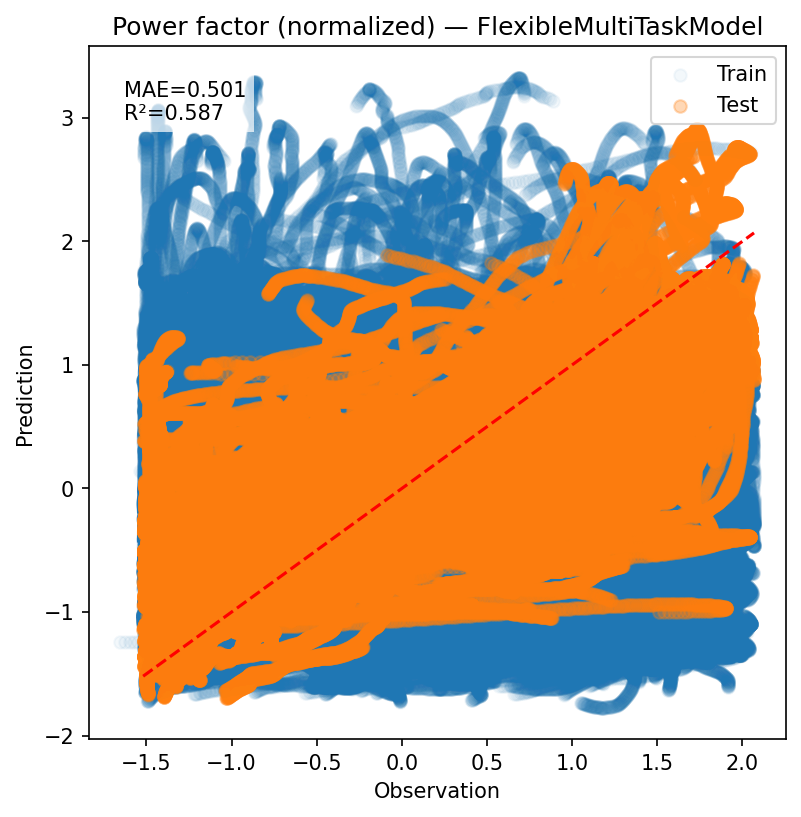

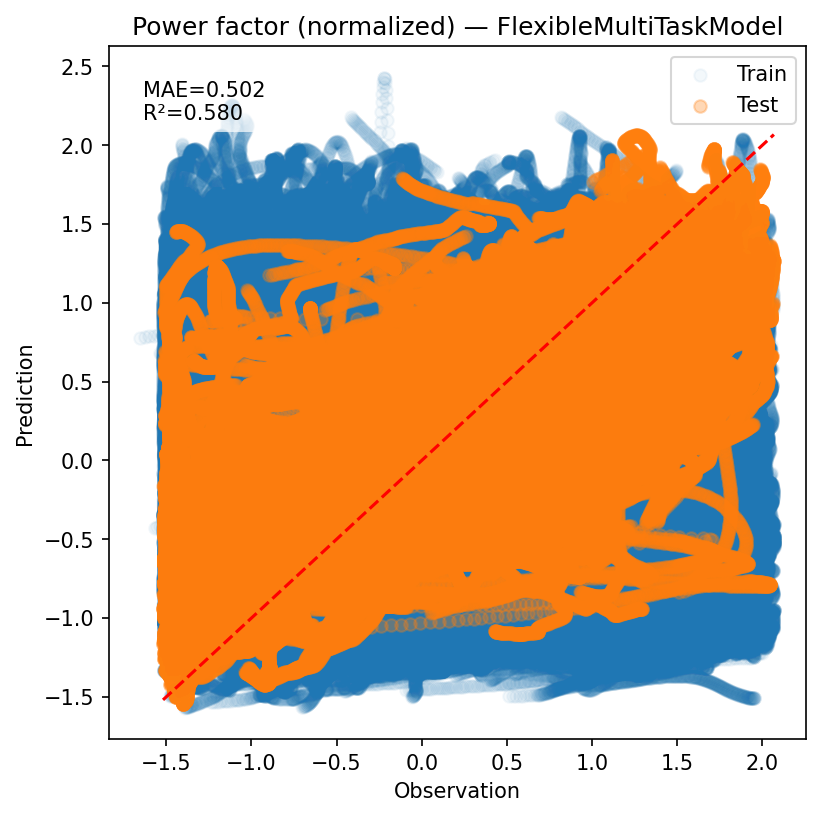

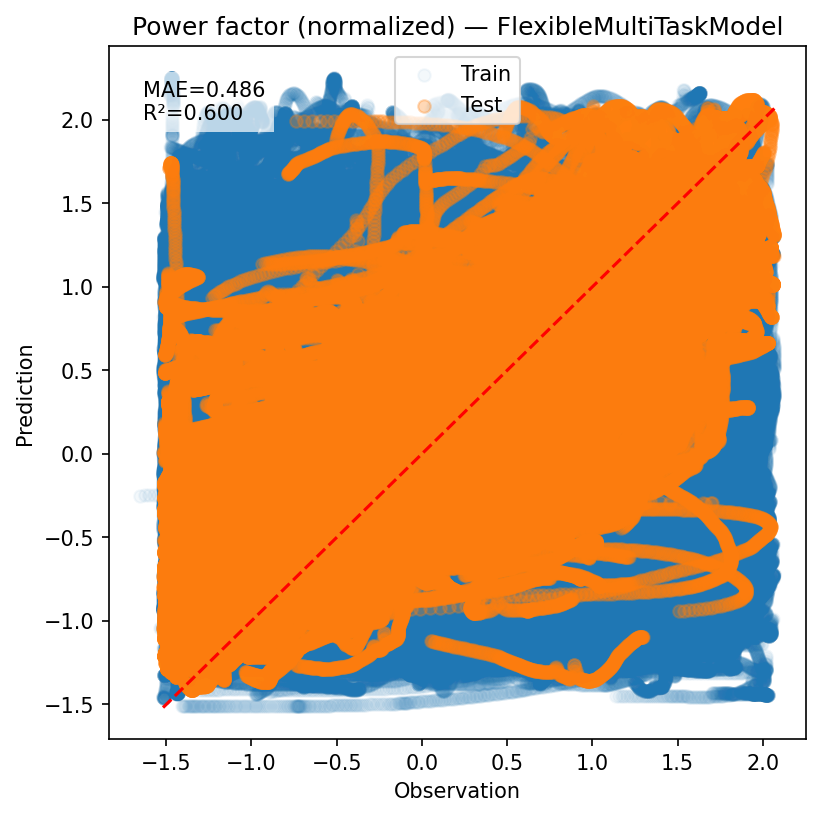

In [8]:
import json

print("\n--- Training FlexibleMultiTaskModel with KernelRegressionHead ---")
_ = seed_everything(2025)

base_dir = Path(
    f"logs/flexible_model_kr_test/{prop_name}/{datetime.now().strftime('%m%d_%H%M')}_nk{N_KERNEL}_r{TRAIN_RATIO}"
)

for n_try in range(N_TRY):
    version = f"trial_{n_try + 1}"
    save_dir = base_dir / "predictions" / version
    save_dir.mkdir(parents=True, exist_ok=True)

    # --- Data split (same as prototype: swap_train_val_split with 0.8 ratio) ---
    split = swap_train_val_split(qc_ac_te_mp_dos_data, swap_ratio=0.8, random_seed=None)
    split = split.loc[prop_value.index]
    attributes_with_split = attributes_df.copy()
    attributes_with_split["split"] = split
    _ = split.to_csv(f"{save_dir}/data_split.csv")

    # --- CompoundDataModule (production DataModule) ---
    dm = CompoundDataModule(
        formula_desc_source=desc,
        attributes_source=attributes_with_split,
        task_configs=[task_config],
        batch_size=BATCH_SIZE,
        num_workers=0,
    )

    # --- FlexibleMultiTaskModel ---
    model = FlexibleMultiTaskModel(
        task_configs=[task_config],
        encoder_config=encoder_config,
        shared_block_optimizer=OptimizerConfig(
            optimizer_type="AdamW", lr=LR_RATE, weight_decay=OTHER_DECAY, scheduler_type="None",
        ),
    )

    callbacks = [
        EarlyStopping(monitor="val_final_loss", mode="min", patience=30),
        ModelCheckpoint(
            monitor="val_final_loss", mode="min", save_top_k=1,
            filename="best-{epoch:02d}-{val_final_loss:.4f}",
        ),
        LearningRateMonitor(logging_interval="epoch"),
    ]
    logger = [
        CSVLogger(base_dir, version=version, name="csv"),
        TensorBoardLogger(base_dir, version=version, name="tensorboard"),
    ]

    trainer = Trainer(
        max_epochs=EPOCHS,
        accelerator="auto",
        devices=[DEVICE_NUM],
        deterministic=True,
        log_every_n_steps=10,
        callbacks=callbacks,
        logger=logger,
    )

    # --- Train ---
    trainer.fit(model, datamodule=dm)

    # --- Predict on test and train sets ---
    # predict_step returns dict: {"power_factor_value": List[np.ndarray]}
    dm.setup(stage="fit")
    dm.setup(stage="test")
    test_preds = trainer.predict(model, dataloaders=dm.test_dataloader())
    train_preds = trainer.predict(model, dataloaders=dm.train_dataloader())

    # --- Collect predictions ---
    pred_key = f"{TASK_NAME}_value"

    def collect_predictions(batch_preds, dataset):
        """Collect ground truth and predictions from batch prediction results."""
        all_y, all_yhat = [], []
        # Ground truth from dataset
        for i in range(len(dataset)):
            sample = dataset[i]
            # sample = (x, y_dict, mask_dict, t_sequences_dict)
            y_seq = sample[1][TASK_NAME]  # target tensor for this sample
            all_y.append(y_seq.numpy())
        # Predictions from trainer.predict output
        for batch_pred in batch_preds:
            if pred_key in batch_pred:
                for arr in batch_pred[pred_key]:
                    all_yhat.append(np.asarray(arr))
        return all_y, all_yhat

    test_y, test_yhat = collect_predictions(test_preds, dm.test_dataset)
    train_y, train_yhat = collect_predictions(train_preds, dm.train_dataset)

    y_true = np.concatenate(test_y)
    y_preds = np.concatenate(test_yhat)
    y_fit_true = np.concatenate(train_y)
    y_fit_preds = np.concatenate(train_yhat)

    # --- Save results ---
    df = pd.DataFrame({
        "true": np.concatenate([y_true, y_fit_true]),
        "prediction": np.concatenate([y_preds, y_fit_preds]),
        "label": ["prediction"] * len(y_true) + ["fit"] * len(y_fit_true),
    })
    df.to_csv(f"{save_dir}/results.csv", index=False)
    df.to_parquet(f"{save_dir}/results.parquet", index=False)

    # --- Scatter plot ---
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    ax.scatter(y_fit_true, y_fit_preds, alpha=0.05, label="Train")
    ax.scatter(y_true, y_preds, alpha=0.3, label="Test")
    ax.set_xlabel("Observation")
    ax.set_ylabel("Prediction")
    ax.set_title(f"{prop_name} (normalized) — FlexibleMultiTaskModel")
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)
    ax.legend()
    ax.text(
        0.05, 0.95, f"MAE={mae:.3f}\nR²={r2:.3f}",
        transform=ax.transAxes, verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

    metrics = {"mae": float(mae), "r2": float(r2)}
    with open(f"{save_dir}/metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)
    fig.savefig(f"{save_dir}/scatter.png", bbox_inches="tight")
    print(f"Trial {n_try + 1}: MAE={mae:.4f}, R²={r2:.4f}")

## 5. 对比总结

运行完成后，比较 `logs/flexible_model_kr_test/` 下的 MAE / R² 与原型 `logs/kernel_regression/` 的结果。

**架构差异说明**（不影响逻辑正确性）：
- 原型：`X → make_mlp(GELU) → y`，直接输入 descriptor
- 生产：`X → Encoder(LeakyReLU) → tanh → KernelRegressionHead(LeakyReLU) → y`
- 激活函数不同（GELU vs LeakyReLU），初始化方式不同（xavier_uniform vs kaiming_normal）
- 数值不会完全一致，但训练趋势和最终量级应一致